### Data Loader

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.dates import date2num

def download_stock_data(ticker: str, start_date: str, end_date: str) -> pd.DataFrame:
    data = yf.download(ticker, start=start_date, end=end_date)
    data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
    data.dropna(inplace=True)
    return data

### Preprocessing

In [2]:

def add_target(data: pd.DataFrame) -> pd.DataFrame:
    data['Target'] = np.where(data['Close'].shift(-1) > data['Close'], 1, 0)
    return data

def create_features(data: pd.DataFrame, sequence_length: int = 60):
    features = []
    targets = []
    for i in range(len(data) - sequence_length):
        features.append(data.iloc[i:i+sequence_length].loc[:, data.columns != 'Target'].values)
        targets.append(data.iloc[i+sequence_length]['Target'])
    return np.array(features), np.array(targets)

def scale_features(data: pd.DataFrame):
    scaler = StandardScaler()
    scaled_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)
    return scaled_data, scaler


### Plotting

In [3]:
def plot_price_and_volume(df, ticker='Stock'):
    dates   = date2num(df.index.to_pydatetime())
    close   = df['Close'].astype(float).values
    volume  = df['Volume'].astype(float).values

    # Flatten volume if it's 2D
    if volume.ndim > 1:
        volume = volume.flatten()

    # Ensure same length
    min_len = min(len(dates), len(volume))
    dates = dates[:min_len]
    close = close[:min_len]
    volume = volume[:min_len]

    fig, ax1 = plt.subplots(figsize=(14, 6))
    ax1.set_title(f"{ticker} – Close & Volume")
    ax1.plot(df.index[:min_len], close)
    ax1.set_ylabel('Close')

    ax2 = ax1.twinx()
    ax2.bar(dates, volume,
            width=1.0,
            alpha=0.3,
            linewidth=0,
            edgecolor='none')
    ax2.set_ylabel('Volume')
    ax2.xaxis_date()

    ax1.grid(True)
    fig.tight_layout()
    plt.show()

### Downloading and preparing sequences for AAPL

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
C:\Users\Baile\AppData\Local\Temp\ipykernel_2192\1607731215.py:4: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_scaled, scaler = scale_features(df.drop(columns=['Target']))


X shape: (2204, 60, 6), y shape: (2204, 1)


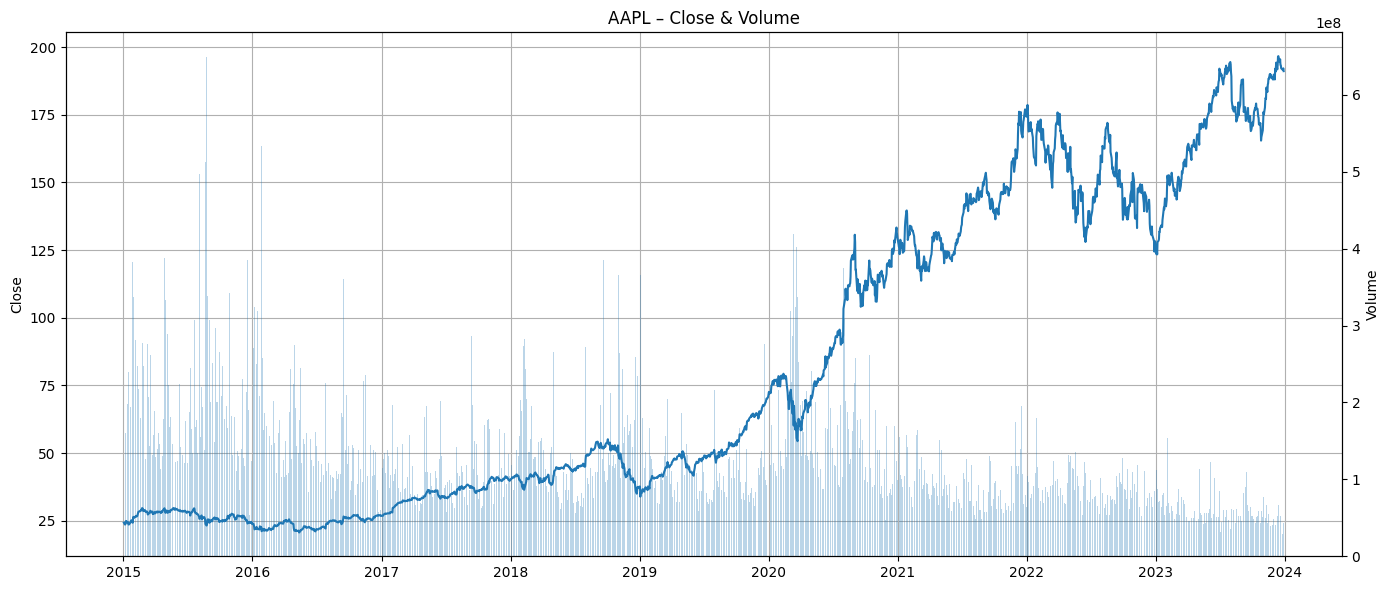

In [ ]:
# Download and prepare data
df = download_stock_data('AAPL', '2015-01-01', '2023-12-31')
df = add_target(df)
df_scaled, scaler = scale_features(df.drop(columns=['Target']))
df_scaled['Target'] = df['Target']  # Add target back

# Create LSTM-ready sequences
X, y = create_features(df_scaled, sequence_length=60)

print(f"X shape: {X.shape}, y shape: {y.shape}")

plot_price_and_volume(df, 'AAPL')

### Export to Python File

In [6]:
%%writefile -a ../src/data_preparation.py
# This file contains functions for downloading stock data, adding targets, creating features, scaling features, and preparing data for LSTM models.

import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.dates import date2num

def download_stock_data(ticker: str, start_date: str, end_date: str) -> pd.DataFrame:
    data = yf.download(ticker, start=start_date, end=end_date)
    data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
    data.dropna(inplace=True)
    return data

def add_target(data: pd.DataFrame) -> pd.DataFrame:
    data['Target'] = np.where(data['Close'].shift(-1) > data['Close'], 1, 0)
    return data

def create_features(data: pd.DataFrame, sequence_length: int = 60):
    features = []
    targets = []
    for i in range(len(data) - sequence_length):
        features.append(data.iloc[i:i+sequence_length].loc[:, data.columns != 'Target'].values)
        targets.append(data.iloc[i+sequence_length]['Target'])
    return np.array(features), np.array(targets)

def scale_features(data: pd.DataFrame):
    scaler = StandardScaler()
    scaled_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)
    return scaled_data, scaler

# The point of this function is to split the data into smaller chunks with a specified length
# this is so the data will be in a format the LSTM model can understand
# the main thing that can be tweeked here is the seq_len, which is just the length of the chunks it wil learn from
def create_lstm_sequences(df, feature_cols, target_col, seq_len=60):
    # select applicable columns
    data = df[feature_cols + [target_col]].values
    X, y = [], []
    
    # loop over data and create overlapping chunks
    for i in range(len(data) - seq_len):
        # X_seq is all feature columns, excluding target
        # and y_val is just target column
        X_seq = data[i : i + seq_len, :-1] 
        y_val = data[i + seq_len, -1]
        X.append(X_seq)
        y.append(y_val)
    
    # convert to np array and float32 because of torch
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    return X, y

Writing ../src/data_preparation.py
